# Plot 2d histograms from quadrant analysis
## Plot multiple simulations at same height z/h

In [1]:
%matplotlib inline
# import functions from python directory
import sys
sys.path.append("/home/bgreene/SBL_LES/python/")
import os
import seaborn
import cmocean
import numpy as np
import xarray as xr
from scipy.stats import gmean
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESnc import load_stats, load_full, MidPointNormalize

In [2]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap2 = seaborn.color_palette("cubehelix_r", as_cmap=True)
cmap4 = cmocean.cm.balance

In [3]:
# directories
# figure save
figdir = "/home/bgreene/SBL_LES/figures/LSM/v2/"
# list of simulations to loop over
sims = ["cr0.10_u08_192", "cr0.25_u08_192", "cr0.33_u08_192", "cr0.50_u08_192", 
        "cr1.00_u08_192", "cr1.50_u08_192", "cr2.00_u08_192", "cr2.50_u08_192"]
# empty list to construct paths and store
dnc_all = []
for sim in sims:
    dnc = f"/home/bgreene/simulations/{sim}/output/netcdf/"
    dnc_all.append(dnc)
    
# loop over sims and load stats and quadrant data
sall = []
qall = []
quadall = []
condall = []
for dnc in dnc_all:
    # load stats file
    s = load_stats(dnc+"average_statistics.nc")
    sall.append(s)
    # load data for 2d histogram
    q = xr.load_dataset(dnc+"u_w_theta_2d_quadrant.nc")
    qall.append(q)
    # load quadrant files
    quad = xr.load_dataset(dnc+"uw_tw_quadrant.nc")
    quadall.append(quad)
    # load conditional average files
    cond = xr.load_dataset(dnc+"cond_avg.nc")
    condall.append(cond)

nsim = len(sall)
cmap3 = seaborn.color_palette("cubehelix_r", nsim)

Reading file: /home/bgreene/simulations/cr0.10_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.33_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.50_u08_192/output/netcdf/average_statistics.nc


## Determine joint distributions
### u' - w'

In [ ]:
# initialize dictionary to store heights and simulations
H_uw_all = {}
# use same bins for each sim
uw_bins = (np.arange(-10., 10.1, 0.1), np.arange(-10., 10.1, 0.1))
# calculate bin area for normalizing later
uw_bin_area = np.diff(uw_bins[0])[0] * np.diff(uw_bins[1])[0]
# loop over heights and sims
for iz, sz in enumerate(np.around(qall[0].zh, 1)):
    sz = str(sz.values)
    H_uw_all[sz] = []
    for s, q in zip(sall, qall):
        # calculate bins and edges
        H_uw, x_uw, y_uw = np.histogram2d(q.u[iz].values/s.ustar0.values, 
                                          q.w[iz].values/s.ustar0.values, 
                                          bins=uw_bins, density=True)
        # normalize sum==1 by multiplying by bin area
        # also multiply by 100% for units
        H_uw *= uw_bin_area * 100.
        # append to big list
        H_uw_all[sz].append(H_uw)
# calculate bin centers
x1 = x_uw[:-1] + np.diff(x_uw)/2
y1 = y_uw[:-1] + np.diff(y_uw)/2

### Plot u' - w' joint dist
Subplots for each simulation and height

In [ ]:
fig1, ax1 = plt.subplots(nrows=len(H_uw_all), ncols=len(qall), 
                         sharex=True, sharey=True, figsize=(30, 14), 
                         constrained_layout=True)
# loop over H_uw_all and contour -- keys(height) and list elements(simulation)
# loop over heights (rows)
for iH, sH in enumerate(H_uw_all.keys()):
    # determine contour levels at each height
    # levels = get_contour_levels(H_uw_all[sH], 21)
    cax1 = []
    # loop over simulations (columns)
    for isim, sim in enumerate(H_uw_all[sH]):
        cax = ax1[iH,isim].contour(x1, y1, H_uw_all[sH][isim].T, cmap=cmap2,
                                   extend="both", levels=11)
        # ax1[iH,isim].clabel(cax, cax.levels, inline=True, fontsize=10)                           
        cax1.append(cax)
    # add colorbars at end of rows
    cb1 = fig1.colorbar(cax1[-1], ax=ax1[iH,:], location="right")
    cb1.ax.set_ylabel("Frequency [\\%]")

# add labels
[iax.set_xlabel("$u'/u_{*}$") for iax in ax1[-1,:]]
[iax.set_ylabel(f"$w'/u_{{*}}$, $z/h={{{sH}}}$") for sH, iax in zip(H_uw_all.keys(), ax1[:,0])]
ax1[0,0].set_xlim([-3, 3])
ax1[0,0].set_ylim([-2, 2])
[iax.axhline(0., c="k", alpha=0.5) for iax in ax1.flatten()]
[iax.axvline(0., c="k", alpha=0.5) for iax in ax1.flatten()]
[iax.set_title(f"$h/L = {{{(sall[i].he/sall[i].L).values:3.2f}}}$") for i, iax in enumerate(ax1[0, :])]
# save figure
fsave = f"{figdir}hist2d_u_w.pdf"
# fig1.savefig(fsave)

### $\theta'$ - $w'$

In [ ]:
# initialize dictionary to store heights and simulations
H_tw_all = {}
# use same bins for each sim
tw_bins = (np.arange(-15., 15.1, 0.1), np.arange(-10., 10.1, 0.1))
# calculate bin area for normalizing later
tw_bin_area = np.diff(tw_bins[0])[0] * np.diff(tw_bins[1])[0]
# loop over heights and sims
for iz, sz in enumerate(np.around(qall[0].zh, 1)):
    sz = str(sz.values)
    H_tw_all[sz] = []
    for s, q in zip(sall, qall):
        # calculate bins and edges
        H_tw, x_tw, y_tw = np.histogram2d(q.theta[iz].values/s.tstar0.values, 
                                          q.w[iz].values/s.ustar0.values, 
                                          bins=tw_bins, density=True)
        # normalize sum==1 by multiplying by bin area
        # also multiply by 100% for units
        H_tw *= tw_bin_area * 100.
        # append to big list
        H_tw_all[sz].append(H_tw)
# calculate bin centers
x2 = x_tw[:-1] + np.diff(x_tw)/2
y2 = y_tw[:-1] + np.diff(y_tw)/2

### Plot $\theta'$ - $w'$ joint

In [ ]:
fig2, ax2 = plt.subplots(nrows=len(H_tw_all), ncols=len(qall), 
                         sharex=True, sharey=True, figsize=(30, 14), 
                         constrained_layout=True)
# loop over H_uw_all and contour -- keys(height) and list elements(simulation)
# loop over heights (rows)
for iH, sH in enumerate(H_tw_all.keys()):
    cax2 = []
    # loop over simulations (columns)
    for isim, sim in enumerate(H_tw_all[sH]):
        cax = ax2[iH,isim].contour(x2, y2, H_tw_all[sH][isim].T, cmap=cmap2,
                                   extend="both", levels=11)
        # ax1[iH,isim].clabel(cax, cax.levels, inline=True, fontsize=10)                           
        cax2.append(cax)
    # add colorbars at end of rows
    cb2 = fig2.colorbar(cax2[-1], ax=ax2[iH,:], location="right")
    cb2.ax.set_ylabel("Frequency [\\%]")

# add labels
[iax.set_xlabel("$\\theta'/\\theta_{*}$") for iax in ax2[-1,:]]
[iax.set_ylabel(f"$w'/u_{{*}}$, $z/h={{{sH}}}$") for sH, iax in zip(H_tw_all.keys(), ax2[:,0])]
ax2[0,0].set_xlim([-5, 5])
ax2[0,0].set_ylim([-2, 2])
[iax.axhline(0., c="k", alpha=0.5) for iax in ax2.flatten()]
[iax.axvline(0., c="k", alpha=0.5) for iax in ax2.flatten()]
[iax.set_title(f"$h/L = {{{(sall[i].he/sall[i].L).values:3.2f}}}$") for i, iax in enumerate(ax2[0, :])]
# save figure
fsave = f"{figdir}hist2d_t_w.pdf"
# fig2.savefig(fsave)

### $\theta'$ - $u'$

In [ ]:
# initialize dictionary to store heights and simulations
H_tu_all = {}
# use same bins for each sim
tu_bins = (np.arange(-15., 15.1, 0.1), np.arange(-10., 10.1, 0.1))
# calculate bin area for normalizing later
tu_bin_area = np.diff(tu_bins[0])[0] * np.diff(tu_bins[1])[0]
# loop over heights and sims
for iz, sz in enumerate(np.around(qall[0].zh, 1)):
    sz = str(sz.values)
    H_tu_all[sz] = []
    for s, q in zip(sall, qall):
        # calculate bins and edges
        H_tu, x_tu, y_tu = np.histogram2d(q.theta[iz].values/s.tstar0.values, 
                                          q.u[iz].values/s.ustar0.values, 
                                          bins=tu_bins, density=True)
        # normalize sum==1 by multiplying by bin area
        # also multiply by 100% for units
        H_tu *= tu_bin_area * 100.
        # append to big list
        H_tu_all[sz].append(H_tu)
# calculate bin centers
x3 = x_tu[:-1] + np.diff(x_tu)/2
y3 = y_tu[:-1] + np.diff(y_tu)/2

In [ ]:
fig3, ax3 = plt.subplots(nrows=len(H_tu_all), ncols=len(qall), 
                         sharex=True, sharey=True, figsize=(30, 14), 
                         constrained_layout=True)
# loop over H_uw_all and contour -- keys(height) and list elements(simulation)
# loop over heights (rows)
for iH, sH in enumerate(H_tu_all.keys()):
    cax3 = []
    # loop over simulations (columns)
    for isim, sim in enumerate(H_tu_all[sH]):
        cax = ax3[iH,isim].contour(x3, y3, H_tu_all[sH][isim].T, cmap=cmap2,
                                   extend="both", levels=11)
        # ax1[iH,isim].clabel(cax, cax.levels, inline=True, fontsize=10)                           
        cax3.append(cax)
    # add colorbars at end of rows
    cb3 = fig2.colorbar(cax3[-1], ax=ax3[iH,:], location="right")
    cb3.ax.set_ylabel("Frequency [\\%]")

# add labels
[iax.set_xlabel("$\\theta'/\\theta_{*}$") for iax in ax3[-1,:]]
[iax.set_ylabel(f"$u'/u_{{*}}$, $z/h={{{sH}}}$") for sH, iax in zip(H_tu_all.keys(), ax3[:,0])]
ax3[0,0].set_xlim([-5, 5])
ax3[0,0].set_ylim([-3, 3])
[iax.axhline(0., c="k", alpha=0.5) for iax in ax3.flatten()]
[iax.axvline(0., c="k", alpha=0.5) for iax in ax3.flatten()]
[iax.set_title(f"$h/L = {{{(sall[i].he/sall[i].L).values:3.2f}}}$") for i, iax in enumerate(ax3[0, :])]
# save figure
fsave = f"{figdir}hist2d_t_u.pdf"
# fig3.savefig(fsave)

# Plot 3x3 1d histograms of $u$, $w$, $theta$

In [ ]:
fig3a, ax3a = plt.subplots(nrows=3, ncols=3, figsize=(14,15))
# columns: z/h = [0.1, 0.5, 0.9]
# rows: u, w, theta
# all sims on all plots with color coding
binu = np.linspace(-5, 5, 51)
binw = np.linspace(-3, 3, 31)
bint = np.linspace(-5, 5, 51)

for ii, (s, q) in enumerate(zip(sall, qall)):
    # z/h=0.1, u
    ax3a[0,0].hist(q.u.isel(zh=0)/s.ustar0, bins=binu, density=True, 
                   histtype="step", color=cmap3[ii])
    # z/h=0.5, u
    ax3a[0,1].hist(q.u.isel(zh=1)/s.ustar0, bins=binu, density=True, 
                   histtype="step", color=cmap3[ii])
    # z/h=0.9, u
    ax3a[0,2].hist(q.u.isel(zh=2)/s.ustar0, bins=binu, density=True, 
                   histtype="step", color=cmap3[ii], label=s.label3)
    # z/h=0.1, w
    ax3a[1,0].hist(q.w.isel(zh=0)/s.ustar0, bins=binw, density=True, 
                   histtype="step", color=cmap3[ii])
    # z/h=0.5, w
    ax3a[1,1].hist(q.w.isel(zh=1)/s.ustar0, bins=binw, density=True, 
                   histtype="step", color=cmap3[ii])
    # z/h=0.9, w
    ax3a[1,2].hist(q.w.isel(zh=2)/s.ustar0, bins=binw, density=True, 
                   histtype="step", color=cmap3[ii])
    # z/h=0.1, t
    ax3a[2,0].hist(q.theta.isel(zh=0)/s.tstar0, bins=bint, density=True, 
                   histtype="step", color=cmap3[ii])
    # z/h=0.5, t
    ax3a[2,1].hist(q.theta.isel(zh=1)/s.tstar0, bins=bint, density=True, 
                   histtype="step", color=cmap3[ii])
    # z/h=0.9, t
    ax3a[2,2].hist(q.theta.isel(zh=2)/s.tstar0, bins=bint, density=True, 
                   histtype="step", color=cmap3[ii])
# labels
for iax in ax3a.flatten():
    iax.set_ylabel("Frequency")
for iax, s in zip(ax3a[0,:], [0.1, 0.5, 0.9]):
    iax.set_xlabel("$u'/u_{*}$")
    iax.set_title(f"$z/h = {{{s}}}$")
for iax in ax3a[1,:]:
    iax.set_xlabel("$w'/u_{*}$")
for iax in ax3a[2,:]:
    iax.set_xlabel("$\\theta'/\\theta_{*}$")

ax3a[0,2].legend(fontsize=10)

fig3a.tight_layout()
# save figure
fsave = f"{figdir}hist1d_3x3.pdf"
# fig3a.savefig(fsave)

In [ ]:
# similar to above, but one sim per plot overlaid each z/h
fig3b, ax3b = plt.subplots(nrows=3, ncols=len(sall), sharey="row", sharex="row",
                           figsize=(30, 15))
for ii, (s, q) in enumerate(zip(sall, qall)):
    # row 1: u'/ustar
    # z/h=0.1, u
    ax3b[0,ii].hist(q.u.isel(zh=0)/s.ustar0, bins=binu, density=True, 
                    histtype="step", color="k", label="$z/h=0.1$")
    # z/h=0.5, u
    ax3b[0,ii].hist(q.u.isel(zh=1)/s.ustar0, bins=binu, density=True, 
                    histtype="step", color="r", label="$z/h=0.5$")
    # z/h=0.9, u
    ax3b[0,ii].hist(q.u.isel(zh=2)/s.ustar0, bins=binu, density=True, 
                    histtype="step", color="b", label="$z/h=0.9$")
    # row 2: w'/ustar
    # z/h=0.1, w
    ax3b[1,ii].hist(q.w.isel(zh=0)/s.ustar0, bins=binu, density=True, 
                    histtype="step", color="k")
    # z/h=0.5, w
    ax3b[1,ii].hist(q.w.isel(zh=1)/s.ustar0, bins=binu, density=True, 
                    histtype="step", color="r")
    # z/h=0.9, w
    ax3b[1,ii].hist(q.w.isel(zh=2)/s.ustar0, bins=binu, density=True, 
                    histtype="step", color="b")
    # row 3: theta'/tstar
    # z/h=0.1, t
    ax3b[2,ii].hist(q.theta.isel(zh=0)/s.tstar0, bins=binu, density=True, 
                    histtype="step", color="k")
    # z/h=0.5, t
    ax3b[2,ii].hist(q.theta.isel(zh=1)/s.tstar0, bins=binu, density=True, 
                    histtype="step", color="r")
    # z/h=0.9, t
    ax3b[2,ii].hist(q.theta.isel(zh=2)/s.tstar0, bins=binu, density=True, 
                    histtype="step", color="b")

ax3b[0,0].legend()

for iax in ax3b[:,0]:
    iax.set_ylabel("Frequency")
for iax, s in zip(ax3b[0,:], sall):
    iax.set_title(s.label3)
    iax.set_xlabel("$u'/u_{*}$")
for iax in ax3b[1,:]:
    iax.set_xlabel("$w'/u_{*}$")
for iax in ax3b[2,:]:
    iax.set_xlabel("$\\theta'/\\theta_{*}$")

fig3b.tight_layout()
# save figure
fsave = f"{figdir}hist1d_u_w_theta.pdf"
# fig3b.savefig(fsave)

# Plot profiles of correlation coefficients $R_{uw}, R_{\theta w}$ and mixing efficiencies $\eta_{uw}, \eta_{\theta w}$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


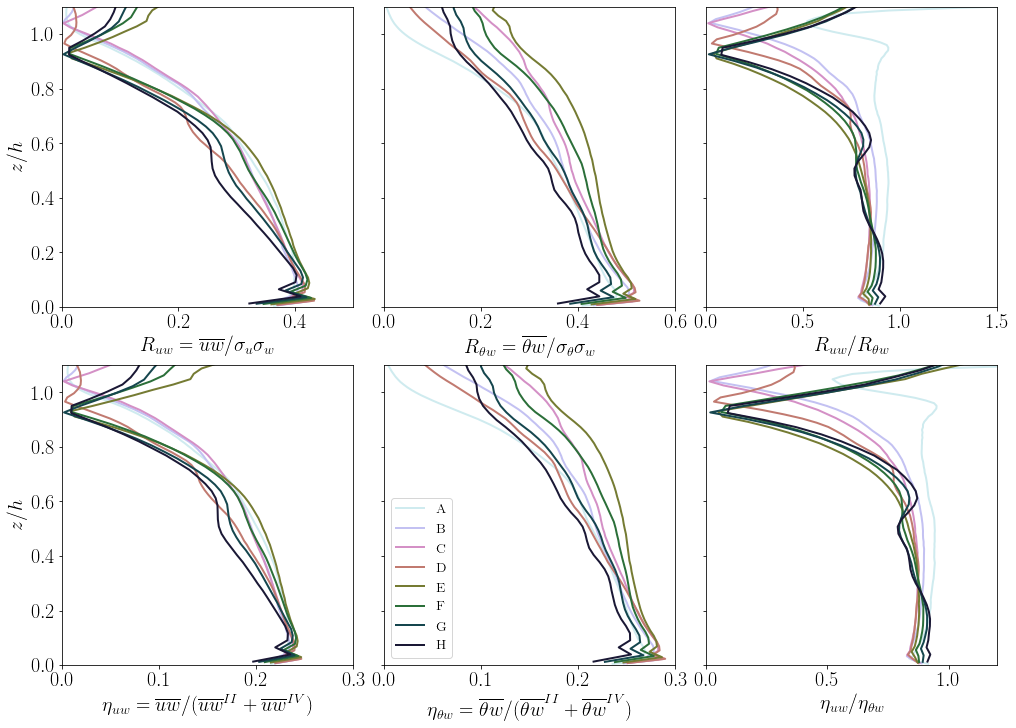

In [5]:
fig4, ax4 = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(14,10), constrained_layout=True)
for ii, (s, q) in enumerate(zip(sall, quadall)):
    # Ruw
    ax4[0,0].plot(q.Ruw, q.z/s.h, ls="-", lw=2, c=cmap3[ii], label=s.lab)
    # Rtw
    ax4[0,1].plot(q.Rtw, q.z/s.h, ls="-", lw=2, c=cmap3[ii], label=s.lab)
    # Ruw / Rtw
    ax4[0,2].plot(q.Ruw/q.Rtw, q.z/s.h, ls="-", lw=2, c=cmap3[ii], label=s.lab)
    # eta_uw
    ax4[1,0].plot(q.eta_uw, q.z/s.h, ls="-", lw=2, c=cmap3[ii], label=s.lab)
    # eta_tw
    ax4[1,1].plot(q.eta_tw, q.z/s.h, ls="-", lw=2, c=cmap3[ii], label=s.lab)
    # eta_uw/eta_tw
    ax4[1,2].plot(q.eta_uw/q.eta_tw, q.z/s.h, ls="-", lw=2, c=cmap3[ii], label=s.lab)

# legend
ax4[1,1].legend(fontsize=14)
# x axis limits
ax4[0,0].set_xlim([0, 0.5])
ax4[0,1].set_xlim([0, 0.6])
ax4[0,2].set_xlim([0, 1.5])
ax4[1,0].set_xlim([0, 0.3])
ax4[1,1].set_xlim([0, 0.3])
ax4[1,2].set_xlim([0, 1.2])
# y axis limits
ax4[1,0].set_ylim([0, 1.1])
# axis labels
ax4[0,0].set_ylabel("$z/h$")
ax4[1,0].set_ylabel("$z/h$")
ax4[0,0].set_xlabel("$R_{uw} = \\overline{uw} / \\sigma_u \\sigma_w$")
ax4[0,1].set_xlabel("$R_{\\theta w} = \\overline{\\theta w} / \\sigma_{\\theta} \\sigma_w$")
ax4[0,2].set_xlabel("$R_{uw}/R_{\\theta w}$")
ax4[1,0].set_xlabel("$\\eta_{uw} = \\overline{uw} / (\\overline{uw}^{II} + \\overline{uw}^{IV})$")
ax4[1,1].set_xlabel("$\\eta_{\\theta w} = \\overline{\\theta w} / (\\overline{\\theta w}^{II} + \\overline{\\theta w}^{IV})$")
ax4[1,2].set_xlabel("$\\eta_{uw} / \\eta_{\\theta w}$")
# save figure
fsave = f"{figdir}R_eta_uw_zh.eps"
fig4.savefig(fsave)

# Profiles of quadrant fractions: $u'w'$

In [ ]:
# u'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 5), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    # quadrant I: u+w+
    ax5[0].plot(np.abs(quad.uw_pp)/np.abs(quad.uw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
    # quadrant II: u-w+
    ax5[1].plot(np.abs(quad.uw_np)/np.abs(quad.uw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
    # quadrant III: u-w-
    ax5[2].plot(np.abs(quad.uw_nn)/np.abs(quad.uw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
    # quadrant II: u+w-
    ax5[3].plot(np.abs(quad.uw_pn)/np.abs(quad.uw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
# clean up
ax5[0].legend(fontsize=14)
ax5[0].set_ylim([0., 1.2])
# ax5[0].set_yscale("log")
ax5[0].set_ylabel("$z/z_j$")
ax5[0].set_xlim([0, 0.5])
[iax.set_xlabel(f"$|\\overline{{uw}}^{{{ii}}}| / \\Sigma | \\overline{{uw}}^k |$") for iax, ii in zip(ax5, ["I", "II", "III", "IV"])]
ax5[0].xaxis.set_major_locator(MultipleLocator(0.2))
[iax.axvline(0.25, color="k") for iax in ax5]
# save figure
fsave = f"{figdir}quad_frac_uw_v3.pdf"
fig5.savefig(fsave)

### Quadrant fractions versus $Ri$, $z/\Lambda$

In [ ]:
# u'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 4), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    isbl = np.arange(3, s.nzsbl, dtype=np.int32)
    # quadrant I: u+w+
    ax5[0].plot(s.Rig[isbl], np.abs(quad.uw_pp[isbl])/np.abs(quad.uw_sum[isbl]), 
                label=s.label3, ls="", marker="*", c=cmap3[ii])
    # quadrant II: u-w+
    ax5[1].plot(s.Rig[isbl], np.abs(quad.uw_np[isbl])/np.abs(quad.uw_sum[isbl]), ls="", marker="*", c=cmap3[ii])
    # quadrant III: u-w-
    ax5[2].plot(s.Rig[isbl], np.abs(quad.uw_nn[isbl])/np.abs(quad.uw_sum[isbl]), ls="", marker="*", c=cmap3[ii])
    # quadrant II: u+w-
    ax5[3].plot(s.Rig[isbl], np.abs(quad.uw_pn[isbl])/np.abs(quad.uw_sum[isbl]), ls="", marker="*", c=cmap3[ii])

ax5[0].set_xscale("log")
ax5[0].set_xlim([1e-2, 1e1])
ax5[0].set_ylim([0., 0.5])
[iax.set_xlabel("$Ri_g$") for iax in ax5]
ax5[0].set_ylabel("$|\\overline{uw}^{k}| / \\Sigma | \\overline{uw}^k |$")
[iax.axhline(0.25, color="k", lw=0.5) for iax in ax5]
fsave = f"{figdir}quad_frac_uw_Ri.pdf"
fig5.savefig(fsave)

In [ ]:
# u'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 4), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    isbl = np.arange(3, s.nzsbl, dtype=np.int32)
    # quadrant I: u+w+
    ax5[0].plot(s.z[isbl]/s.LL, (np.abs(quad.uw_pp)/np.abs(quad.uw_sum))[isbl], 
                label=s.label3, ls="", marker="*", c=cmap3[ii])
    # quadrant II: u-w+
    ax5[1].plot(s.z[isbl]/s.LL, (np.abs(quad.uw_np)/np.abs(quad.uw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant III: u-w-
    ax5[2].plot(s.z[isbl]/s.LL, (np.abs(quad.uw_nn)/np.abs(quad.uw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant II: u+w-
    ax5[3].plot(s.z[isbl]/s.LL, (np.abs(quad.uw_pn)/np.abs(quad.uw_sum))[isbl], ls="", marker="*", c=cmap3[ii])

ax5[0].set_xscale("log")
ax5[0].set_xlim([1e-2, 1e3])
ax5[0].set_ylim([0., 0.5])
[iax.set_xlabel("$z/\\Lambda$") for iax in ax5]
ax5[0].set_ylabel("$|\\overline{uw}^{k}| / \\Sigma | \\overline{uw}^k |$")
[iax.axhline(0.25, color="k", lw=0.5) for iax in ax5]
fsave = f"{figdir}quad_frac_uw_zL.pdf"
fig5.savefig(fsave)

In [ ]:
# u'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 4), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    isbl = np.arange(3, s.nzsbl, dtype=np.int32)
    # quadrant I: u+w+
    ax5[0].plot(s.z[isbl]/s.zj, (np.abs(quad.uw_pp)/np.abs(quad.uw_sum))[isbl], 
                label=s.label3, ls="", marker="*", c=cmap3[ii])
    # quadrant II: u-w+
    ax5[1].plot(s.z[isbl]/s.zj, (np.abs(quad.uw_np)/np.abs(quad.uw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant III: u-w-
    ax5[2].plot(s.z[isbl]/s.zj, (np.abs(quad.uw_nn)/np.abs(quad.uw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant II: u+w-
    ax5[3].plot(s.z[isbl]/s.zj, (np.abs(quad.uw_pn)/np.abs(quad.uw_sum))[isbl], ls="", marker="*", c=cmap3[ii])

ax5[0].set_xscale("log")
ax5[0].set_xlim([1e-2, 1.5e0])
ax5[0].set_ylim([0., 0.5])
[iax.set_xlabel("$z/ z_j$") for iax in ax5]
ax5[0].set_ylabel("$|\\overline{uw}^{k}| / \\Sigma | \\overline{uw}^k |$")
[iax.axhline(0.25, color="k", lw=0.5) for iax in ax5]
[iax.axvline(1, color="k", lw=0.5) for iax in ax5]
fsave = f"{figdir}quad_frac_uw_zzj.pdf"
fig5.savefig(fsave)

# Quadrant fractions: $\theta'w'$

In [ ]:
# theta'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 5), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    # quadrant I: u+w+
    ax5[0].plot(np.abs(quad.tw_pp)/np.abs(quad.tw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
    # quadrant II: u-w+
    ax5[1].plot(np.abs(quad.tw_np)/np.abs(quad.tw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
    # quadrant III: u-w-
    ax5[2].plot(np.abs(quad.tw_nn)/np.abs(quad.tw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
    # quadrant II: u+w-
    ax5[3].plot(np.abs(quad.tw_pn)/np.abs(quad.tw_sum), s.z/s.zj, ls="-", lw=2, c=cmap3[ii], label=s.label3)
# clean up
ax5[0].legend(fontsize=14)
ax5[0].set_ylim([0, 1.2])
ax5[0].set_ylabel("$z/z_j$")
ax5[0].set_xlim([0, 0.5])
[iax.set_xlabel(f"$|\\overline{{\\theta w}}^{{{ii}}}| / \\Sigma | \\overline{{\\theta w}}^k |$") for iax, ii in zip(ax5, ["I", "II", "III", "IV"])]
ax5[0].xaxis.set_major_locator(MultipleLocator(0.2))
[iax.axvline(0.25, color="k") for iax in ax5]
fsave = f"{figdir}quad_frac_tw_v3.pdf"
fig5.savefig(fsave)

In [ ]:
# theta'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 4), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    isbl = np.arange(3, s.nzsbl, dtype=np.int32)
    # quadrant I: u+w+
    ax5[0].plot(s.Rig[isbl], np.abs(quad.tw_pp[isbl])/np.abs(quad.tw_sum[isbl]), 
                label=s.label3, ls="", marker="*", c=cmap3[ii])
    # quadrant II: u-w+
    ax5[1].plot(s.Rig[isbl], np.abs(quad.tw_np[isbl])/np.abs(quad.tw_sum[isbl]), ls="", marker="*", c=cmap3[ii])
    # quadrant III: u-w-
    ax5[2].plot(s.Rig[isbl], np.abs(quad.tw_nn[isbl])/np.abs(quad.tw_sum[isbl]), ls="", marker="*", c=cmap3[ii])
    # quadrant II: u+w-
    ax5[3].plot(s.Rig[isbl], np.abs(quad.tw_pn[isbl])/np.abs(quad.tw_sum[isbl]), ls="", marker="*", c=cmap3[ii])

ax5[0].set_xscale("log")
ax5[0].set_xlim([1e-2, 1e1])
ax5[0].set_ylim([0.0, 0.5])
[iax.set_xlabel("$Ri_g$") for iax in ax5]
ax5[0].set_ylabel("$|\\overline{\\theta w}^{k}| / \\Sigma | \\overline{\\theta w}^k |$")
[iax.axhline(0.25, color="k", alpha=0.5) for iax in ax5]
fsave = f"{figdir}quad_frac_tw_Ri.pdf"
fig5.savefig(fsave)

In [ ]:
# theta'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 4), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    isbl = np.arange(3, s.nzsbl, dtype=np.int32)
    # quadrant I: u+w+
    ax5[0].plot(s.z[isbl]/s.zj, (np.abs(quad.tw_pp)/np.abs(quad.tw_sum))[isbl], 
                label=s.label3, ls="", marker="*", c=cmap3[ii])
    # quadrant II: u-w+
    ax5[1].plot(s.z[isbl]/s.zj, (np.abs(quad.tw_np)/np.abs(quad.tw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant III: u-w-
    ax5[2].plot(s.z[isbl]/s.zj, (np.abs(quad.tw_nn)/np.abs(quad.tw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant II: u+w-
    ax5[3].plot(s.z[isbl]/s.zj, (np.abs(quad.tw_pn)/np.abs(quad.tw_sum))[isbl], ls="", marker="*", c=cmap3[ii])

ax5[0].set_xscale("log")
# ax5[0].set_xlim([1e-2, 1e3])
ax5[0].set_ylim([0., 0.5])
[iax.set_xlabel("$z/z_j$") for iax in ax5]
ax5[0].set_ylabel("$|\\overline{\\theta w}^{k}| / \\Sigma | \\overline{\\theta w}^k |$")
[iax.axhline(0.25, color="k", lw=0.5) for iax in ax5]
fsave = f"{figdir}quad_frac_tw_zzj.pdf"
fig5.savefig(fsave)

In [ ]:
# theta'w'
fig5, ax5 = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(14.8, 4), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    isbl = np.arange(3, s.nzsbl, dtype=np.int32)
    # quadrant I: u+w+
    ax5[0].plot(s.z[isbl]/s.LL, (np.abs(quad.tw_pp)/np.abs(quad.tw_sum))[isbl], 
                label=s.label3, ls="", marker="*", c=cmap3[ii])
    # quadrant II: u-w+
    ax5[1].plot(s.z[isbl]/s.LL, (np.abs(quad.tw_np)/np.abs(quad.tw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant III: u-w-
    ax5[2].plot(s.z[isbl]/s.LL, (np.abs(quad.tw_nn)/np.abs(quad.tw_sum))[isbl], ls="", marker="*", c=cmap3[ii])
    # quadrant II: u+w-
    ax5[3].plot(s.z[isbl]/s.LL, (np.abs(quad.tw_pn)/np.abs(quad.tw_sum))[isbl], ls="", marker="*", c=cmap3[ii])

ax5[0].set_xscale("log")
ax5[0].set_xlim([1e-2, 1e3])
ax5[0].set_ylim([0., 0.5])
[iax.set_xlabel("$z/\\Lambda$") for iax in ax5]
ax5[0].set_ylabel("$|\\overline{\\theta w}^{k}| / \\Sigma | \\overline{\\theta w}^k |$")
[iax.axhline(0.25, color="k", lw=0.5) for iax in ax5]
fsave = f"{figdir}quad_frac_tw_zL.pdf"
fig5.savefig(fsave)

# Transport efficiencies versus a bunch of other things

In [ ]:
fig6, ax6 = plt.subplots(nrows=3, ncols=3, sharex="col", sharey="row", figsize=(14.8, 12),
                         constrained_layout=True)
for ii, (s, q) in enumerate(zip(sall, quadall)):
    isbl = np.arange(3, s.nzsbl, dtype=np.int32)
    iL = np.where(s.z[isbl]/s.L > 1)[0]
    # plot versus z/Lambda
    # Ruw
    ax6[0,0].plot(s.z[isbl]/s.LL[isbl], q.eta_uw[isbl], "x", ls="", c=cmap3[ii])
    # Rtw
    ax6[1,0].plot(s.z[isbl]/s.LL[isbl], q.eta_tw[isbl], "x", ls="", c=cmap3[ii])
    # Ruw / Rtw
    ax6[2,0].plot(s.z[isbl]/s.LL[isbl], q.eta_uw[isbl]/q.eta_tw[isbl], "x", ls="", c=cmap3[ii])
    # plot versus something
    # calculate LM = ustar / dudz
    s["LM"] = s.ustar[isbl] / s.du_dz[isbl]
    # calculate stress intensity ratio c^2
    s["c2"] = s.ustar2[isbl]/s.e
    # Ruw
    ax6[0,1].plot(s.z[isbl]/s.zj, q.eta_uw[isbl], "x", ls="", c=cmap3[ii])
    # Rtw
    ax6[1,1].plot(s.z[isbl]/s.zj, q.eta_tw[isbl], "x", ls="", c=cmap3[ii])
    # Ruw / Rtw
    ax6[2,1].plot(s.z[isbl]/s.zj, q.eta_uw[isbl]/q.eta_tw[isbl], "x", ls="", c=cmap3[ii])
    # plot versus Ri
    # Ruw
    ax6[0,2].plot(s.Rig[isbl], q.eta_uw[isbl], "x", ls="", c=cmap3[ii])
    # Rtw
    ax6[1,2].plot(s.Rig[isbl], q.eta_tw[isbl], "x", ls="", c=cmap3[ii])
    # Ruw / Rtw
    ax6[2,2].plot(s.Rig[isbl], q.eta_uw[isbl]/q.eta_tw[isbl], "x", ls="", c=cmap3[ii])

ax6[0,0].set_xscale("log")
# ax6[0,0].set_xlim([1e-2, 1e2])
ax6[0,0].set_ylabel("$\\eta_{uw}$")
ax6[1,0].set_xscale("log")
ax6[1,0].set_xlim([1e-2, 1e3])
ax6[1,0].set_ylabel("$\\eta_{\\theta w}$")
ax6[2,0].set_xlabel("$z/\\Lambda$")
ax6[2,0].set_ylabel("$\\eta_{uw} / \\eta_{\\theta w}$")
ax6[2,0].set_ylim([0.0, 1.5])
# ax6[2,0].set_yscale("log")

ax6[2,1].set_xscale("log")
ax6[2,1].set_xlim([3e-2, 1.2e0])
# ax6[2,1].set_xlabel("$L_s/\kappa z$")
ax6[2,1].set_xlabel("$z / z_j$")

ax6[2,2].set_xscale("log")
ax6[2,2].set_xlim([1e-2, 1e1])
ax6[2,2].set_xlabel("$Ri_g$")
for iax in ax6[:,2]:
    iax.axvline(0.2, c="k", ls="--", lw=0.5)
for iax in ax6[:,1]:
    iax.axvline(1, c="k", ls="--", lw=0.5)
fsave = f"{figdir}eta_uw_tw_3x3.pdf"
fig6.savefig(fsave)

In [ ]:
ntot = 0
for s in sall:
    ntot += s.nzsbl
    print(f"nsbl = {s.nzsbl}")
print(f"ntot = {ntot}")

# Plot transport efficiencies as box and whisker plots versus Richardson number $Ri_g$

In [ ]:
# Need to create bins
# strategy 1: logspace in Rig
# strategy 2: sort all points by Rig and plot bins of N points each

# start with strategy 1
# dump all values of Rig, Ruw, and Rtw into new 1d arrays to then sort by Rig
# initialize empty arrays
# first need to know how many points there are total in all sims
ntot = 0
for s in sall:
    isbl = np.where(s.z <= s.he)[0]
    nsbl = len(isbl)
    ntot += nsbl
# initialize empty arrays
Rig_all, Ruw_all, Rtw_all = [np.zeros((ntot), dtype=np.float64) for _ in range(3)]

# loop over arrays and store values into these new long arrays
count = 0
for s in sall:
    # only look within sbl
    isbl = np.where(s.z <= s.he)[0]
    # number of values for indexing
    nsbl = len(isbl)
    # assign
    Rig_all[count:count+nsbl] = s.Rig[isbl].values
    Ruw_all[count:count+nsbl] = s.Ruw[isbl].values
    Rtw_all[count:count+nsbl] = s.Rtw[isbl].values
    count += nsbl

In [ ]:
# now sort Rig_all
isort = np.argsort(Rig_all)
# new arrays with sorted values for further processing
Rig = Rig_all[isort]
Ruw = Ruw_all[isort]
Rtw = Rtw_all[isort]
# can also calculate ratio Ruwtw
Ruwtw = Ruw / Rtw

# define bin edges
Ribin = np.logspace(-2, 1, 30)
# calculate bin centers for plotting later
Ribin_mid = []
for iR in range(len(Ribin)-1):
    Ribin_mid.append(gmean([Ribin[iR], Ribin[iR+1]]))
Ribin_mid = np.array(Ribin_mid)

# define empty lists for storing binned data
Ruw_bin, Rtw_bin, Ruwtw_bin = [[] for _ in range(3)]
# loop over bins and store arrays
for iR in range(len(Ribin)-1):
    ibin = np.where((Rig > Ribin[iR]) & (Rig <= Ribin[iR+1]))[0]
    Ruw_bin.append(Ruw[ibin])
    Rtw_bin.append(Rtw[ibin])
    Ruwtw_bin.append(Ruwtw[ibin])

In [ ]:
fig7, ax7 = plt.subplots(1)
stdlo = []
stdhi = []
for ib, bb in enumerate(Ruwtw_bin):
    ax7.plot(Ribin_mid[ib], np.nanmedian(bb), "*k")
    ax7.plot(Ribin_mid[ib], np.nanmean(bb), "*r")
    stdlo.append(np.nanmean(bb)-np.nanstd(bb))
    stdhi.append(np.nanmean(bb)+np.nanstd(bb))
ax7.fill_between(Ribin_mid, stdlo, stdhi, alpha=0.3, color="r")

ax7.set_xscale("log")
ax7.axvline(0.20, c="k")
ax7.set_ylim([0, 2])

In [ ]:
fig, ax = plt.subplots(1, figsize=(7.4, 4))

w = 0.08
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

ax.boxplot(Ruwtw_bin, positions=Ribin_mid, widths=width(Ribin_mid,w))

ax.set_xscale("log")
ax.set_ylim([0, 2])
ax.set_xlim([1e-2, 1e1])

## Plot transport efficiencies as box and whisker plots versus $z/z_j$
### This appears to be the best discriminator 
### Assign bins by count

In [ ]:
# Need to create bins
# strategy 1: logspace in z/zj
# strategy 2: sort all points by z/zj and plot bins of N points each

# implement strategy 2
# dump all values of z/zj, Ruw, and Rtw into new 1d arrays to then sort by zzj
# also include etauw, etatw, etauwtw
# initialize empty arrays
# first need to know how many points there are total in all sims
ntot = 0
for s in sall:
    isbl = np.where(s.z <= s.he)[0]
    nsbl = len(isbl)
    ntot += nsbl
# initialize empty arrays
zzj_all, Ruw_all, Rtw_all, euw_all, etw_all = [np.zeros((ntot), dtype=np.float64) for _ in range(5)]

# loop over arrays and store values into these new long arrays
count = 0
for s in sall:
    # only look within sbl
    isbl = np.where(s.z <= s.he)[0]
    # number of values for indexing
    nsbl = len(isbl)
    # assign
    zzj_all[count:count+nsbl] = (s.z[isbl]/s.zj).values
    Ruw_all[count:count+nsbl] = s.Ruw[isbl].values
    Rtw_all[count:count+nsbl] = s.Rtw[isbl].values
    euw_all[count:count+nsbl] = s.eta_uw[isbl].values
    etw_all[count:count+nsbl] = s.eta_tw[isbl].values
    count += nsbl

# now sort zzj_all
isort = np.argsort(zzj_all)
# new arrays with sorted values for further processing
zzj = zzj_all[isort]
Ruw = Ruw_all[isort]
Rtw = Rtw_all[isort]
euw = euw_all[isort]
etw = etw_all[isort]
# remove nans
zzj = zzj[~np.isnan(zzj)]
Ruw = Ruw[~np.isnan(Ruw)]
Rtw = Rtw[~np.isnan(Rtw)]
euw = euw[~np.isnan(euw)]
etw = etw[~np.isnan(etw)]
# can also calculate ratio Ruwtw
Ruwtw = Ruw / Rtw
euwtw = euw / etw

# loop along sorted arrays and group into bins of size Nperbin
Nperbin = 40
# calculate number of bins based on number of points
Nbin = int(np.ceil(len(zzj)/Nperbin))

# define empty lists for storing binned data
zzj_bin, Ruw_bin, Rtw_bin, Ruwtw_bin, euw_bin, etw_bin, euwtw_bin, zzjbin_mid = [[] for _ in range(8)]
# now loop over groups
for jbin in range(Nbin):
    # define indices that increment
    ilo = jbin * Nperbin
    ihi = ilo + Nperbin
    # check to see if ihi will be out of range
    if ihi >= len(zzj):
        ihi = -1
    # grab data
    zzj_bin.append(zzj[ilo:ihi])
    Ruw_bin.append(Ruw[ilo:ihi])
    Rtw_bin.append(Rtw[ilo:ihi])
    Ruwtw_bin.append(Ruwtw[ilo:ihi])
    euw_bin.append(euw[ilo:ihi])
    etw_bin.append(etw[ilo:ihi])
    euwtw_bin.append(euwtw[ilo:ihi])
    # now can calculate midpoints of zzj for plotting
    zzjbin_mid.append(gmean(zzj_bin[jbin]))
# convert to numpy array
zzjbin_mid = np.array(zzjbin_mid)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey="row", figsize=(14.8, 12))

# parameters for boxplots in logspace
w = 0.025
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

# plot
# col 1: R
ax[0,0].boxplot(Ruw_bin, positions=zzjbin_mid, widths=width(zzjbin_mid,w))
ax[1,0].boxplot(Rtw_bin, positions=zzjbin_mid, widths=width(zzjbin_mid,w))
ax[2,0].boxplot(Ruwtw_bin, positions=zzjbin_mid, widths=width(zzjbin_mid,w))
# col 2: eta
ax[0,1].boxplot(euw_bin, positions=zzjbin_mid, widths=width(zzjbin_mid,w))
ax[1,1].boxplot(etw_bin, positions=zzjbin_mid, widths=width(zzjbin_mid,w))
ax[2,1].boxplot(euwtw_bin, positions=zzjbin_mid, widths=width(zzjbin_mid,w))

# labels
ax[0,0].set_title("$R$")
ax[0,0].set_ylabel("$R_{uw}$")
ax[0,0].set_ylim([0, 0.4])

ax[1,0].set_ylabel("$R_{\\theta w}$")
ax[1,0].set_ylim([0, 0.4])

ax[2,0].set_xscale("log")
ax[2,0].set_ylim([0, 2])
ax[2,0].set_xlim([1e-1, 2e0])
ax[2,0].set_xlabel("$z/z_j$")
ax[2,0].set_ylabel("$R_{uw}/R_{\\theta w}$")

ax[0,1].set_title("$\\eta$")
ax[0,1].set_ylabel("$\\eta_{uw}$")
ax[1,1].set_ylabel("$\\eta_{\\theta w}$")
ax[2,1].set_ylabel("$\\eta_{uw}/\\eta_{\\theta w}$")
ax[2,1].set_xlabel("$z/z_j$")

## Try sorting again by $Ri_g$ but with equal numbers per bin

In [ ]:
# Need to create bins
# strategy 1: logspace in Rig
# strategy 2: sort all points by Rig and plot bins of N points each

# implement strategy 2
# dump all values of Rig, Ruw, and Rtw into new 1d arrays to then sort by Rig
# also include etauw, etatw, etauwtw
# initialize empty arrays
# first need to know how many points there are total in all sims
ntot = 0
for s in sall:
    isbl = np.where(s.z <= s.he)[0]
    nsbl = len(isbl)
    ntot += nsbl
# initialize empty arrays
Rig_all, Ruw_all, Rtw_all, euw_all, etw_all = [np.zeros((ntot), dtype=np.float64) for _ in range(5)]

# loop over arrays and store values into these new long arrays
count = 0
for s in sall:
    # only look within sbl
    isbl = np.where(s.z <= s.he)[0]
    # number of values for indexing
    nsbl = len(isbl)
    # assign
    Rig_all[count:count+nsbl] = s.Rig[isbl].values
    Ruw_all[count:count+nsbl] = s.Ruw[isbl].values
    Rtw_all[count:count+nsbl] = s.Rtw[isbl].values
    euw_all[count:count+nsbl] = s.eta_uw[isbl].values
    etw_all[count:count+nsbl] = s.eta_tw[isbl].values
    count += nsbl

# now sort Rig_all
isort = np.argsort(Rig_all)
# new arrays with sorted values for further processing
Rig = Rig_all[isort]
Ruw = Ruw_all[isort]
Rtw = Rtw_all[isort]
euw = euw_all[isort]
etw = etw_all[isort]
# remove nans
Rig = Rig[~np.isnan(Rig)]
Ruw = Ruw[~np.isnan(Ruw)]
Rtw = Rtw[~np.isnan(Rtw)]
euw = euw[~np.isnan(euw)]
etw = etw[~np.isnan(etw)]

# can also calculate ratio Ruwtw
Ruwtw = Ruw / Rtw
euwtw = euw / etw

# loop along sorted arrays and group into bins of size Nperbin
Nperbin = 40
# calculate number of bins based on number of points
Nbin = int(np.ceil(len(Rig)/Nperbin))

# define empty lists for storing binned data
Rig_bin, Ruw_bin, Rtw_bin, Ruwtw_bin, euw_bin, etw_bin, euwtw_bin, Rigbin_mid = [[] for _ in range(8)]
# now loop over groups
for jbin in range(Nbin):
    # define indices that increment
    ilo = jbin * Nperbin
    ihi = ilo + Nperbin
    # check to see if ihi will be out of range
    if ihi >= len(zzj):
        ihi = -1
    # grab data
    Rig_bin.append(Rig[ilo:ihi])
    Ruw_bin.append(Ruw[ilo:ihi])
    Rtw_bin.append(Rtw[ilo:ihi])
    Ruwtw_bin.append(Ruwtw[ilo:ihi])
    euw_bin.append(euw[ilo:ihi])
    etw_bin.append(etw[ilo:ihi])
    euwtw_bin.append(euwtw[ilo:ihi])
    # now can calculate midpoints of Rig for plotting
    Rigbin_mid.append(gmean(Rig_bin[jbin]))
# convert to numpy array
Rigbin_mid = np.array(Rigbin_mid)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey="row", figsize=(14.8, 12))

# parameters for boxplots in logspace
w = 0.025
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

# plot
# col 1: R
ax[0,0].boxplot(Ruw_bin, positions=Rigbin_mid, widths=width(Rigbin_mid,w))
ax[1,0].boxplot(Rtw_bin, positions=Rigbin_mid, widths=width(Rigbin_mid,w))
ax[2,0].boxplot(Ruwtw_bin, positions=Rigbin_mid, widths=width(Rigbin_mid,w))
# col 2: eta
ax[0,1].boxplot(euw_bin, positions=Rigbin_mid, widths=width(Rigbin_mid,w))
ax[1,1].boxplot(etw_bin, positions=Rigbin_mid, widths=width(Rigbin_mid,w))
ax[2,1].boxplot(euwtw_bin, positions=Rigbin_mid, widths=width(Rigbin_mid,w))

# labels
ax[0,0].set_title("$R$")
ax[0,0].set_ylabel("$R_{uw}$")
ax[0,0].set_ylim([0, 0.4])

ax[1,0].set_ylabel("$R_{\\theta w}$")
ax[1,0].set_ylim([0, 0.4])

ax[2,0].set_xscale("log")
ax[2,0].set_ylim([0, 2])
ax[2,0].set_xlim([1e-2, 1e0])
ax[2,0].set_xlabel("$Ri_g$")
ax[2,0].set_ylabel("$R_{uw}/R_{\\theta w}$")

ax[0,1].set_title("$\\eta$")
ax[0,1].set_ylabel("$\\eta_{uw}$")
ax[1,1].set_ylabel("$\\eta_{\\theta w}$")
ax[2,1].set_ylabel("$\\eta_{uw}/\\eta_{\\theta w}$")
ax[2,1].set_xlabel("$Ri_g$")

# Plot conditionally averaged fields

In [ ]:
vort_y = s.he * (c.u_cond_w_lo_2.differentiate("z", 2) - c.w_cond_w_lo_2.differentiate("x", 2)).compute()

In [ ]:
# plot
fig10a, ax10a = plt.subplots(1, figsize=(14.8, 5))
cax = ax10a.contourf(c.x/s.he, c.z/s.he, vort_y.T, extend="both", cmap=cmap4,
                     levels=np.linspace(-30, 30, 151))
cax2 = ax10a.contour(c.x/s.he, c.z/s.he, c.T_cond_w_lo_2.T, 
                     levels=levelt, colors="k", alpha=0.5)
ax10a.clabel(cax2, fontsize=12, inline=True)
cb = fig10a.colorbar(cax, ax=ax10a, location="right", ticks=MultipleLocator(10))
cb.ax.set_ylabel("$h \\hat{\\omega}_y$")
ax10a.set_xlim([-1, 1])
ax10a.set_ylim([0, 1])
ax10a.set_xlabel("$\\Delta x / h$")
ax10a.set_ylabel("$z/h$")
ax10a.set_title("Nondim y-vort conditioned on $w_{lo}$ at $z/h = 0.50$")
fig10a.tight_layout()

### Idea: calculate vorticity and and plot with temperature for all sims and conditions

In [ ]:
# calculate vorticity and store back in condall
for s, c in zip(sall, condall):
    # u lo
    c["vorty_u_lo_1"] = s.he * (c.u_cond_u_lo_1.differentiate("z", 2) -\
                                c.w_cond_u_lo_1.differentiate("x", 2)).compute()
    c["vorty_u_lo_2"] = s.he * (c.u_cond_u_lo_2.differentiate("z", 2) -\
                                c.w_cond_u_lo_2.differentiate("x", 2)).compute()
    c["vorty_u_lo_3"] = s.he * (c.u_cond_u_lo_3.differentiate("z", 2) -\
                                c.w_cond_u_lo_3.differentiate("x", 2)).compute()
    # u hi
    c["vorty_u_hi_1"] = s.he * (c.u_cond_u_hi_1.differentiate("z", 2) -\
                                c.w_cond_u_hi_1.differentiate("x", 2)).compute()
    c["vorty_u_hi_2"] = s.he * (c.u_cond_u_hi_2.differentiate("z", 2) -\
                                c.w_cond_u_hi_2.differentiate("x", 2)).compute()
    c["vorty_u_hi_3"] = s.he * (c.u_cond_u_hi_3.differentiate("z", 2) -\
                                c.w_cond_u_hi_3.differentiate("x", 2)).compute()
    # w lo
    c["vorty_w_lo_1"] = s.he * (c.u_cond_w_lo_1.differentiate("z", 2) -\
                                c.w_cond_w_lo_1.differentiate("x", 2)).compute()
    c["vorty_w_lo_2"] = s.he * (c.u_cond_w_lo_2.differentiate("z", 2) -\
                                c.w_cond_w_lo_2.differentiate("x", 2)).compute()
    c["vorty_w_lo_3"] = s.he * (c.u_cond_w_lo_3.differentiate("z", 2) -\
                                c.w_cond_w_lo_3.differentiate("x", 2)).compute()
    # w hi
    c["vorty_w_hi_1"] = s.he * (c.u_cond_w_hi_1.differentiate("z", 2) -\
                                c.w_cond_w_hi_1.differentiate("x", 2)).compute()
    c["vorty_w_hi_2"] = s.he * (c.u_cond_w_hi_2.differentiate("z", 2) -\
                                c.w_cond_w_hi_2.differentiate("x", 2)).compute()
    c["vorty_w_hi_3"] = s.he * (c.u_cond_w_hi_3.differentiate("z", 2) -\
                                c.w_cond_w_hi_3.differentiate("x", 2)).compute()

### u lo 1

In [ ]:
fig10, ax10 = plt.subplots(nrows=nsim, ncols=1, sharex=True, sharey=True, 
                           constrained_layout=True, figsize=(14.8, 2.5*nsim))
# vorticity and theta levels
levelv = np.linspace(-30, 30, 151)
levelt = np.linspace(-2, 2, 9)
# list of cfax and cax
cfax10, cax10 = [], []
# loop over sims to plot vort and theta
for ii, (s, c) in enumerate(zip(sall, condall)):
    # colorfill vorticity
    cfax = ax10[ii].contourf(c.x/s.he, c.z/s.he, c.vorty_u_lo_1.T, extend="both", cmap=cmap4,
                            levels=levelv)
    cfax10.append(cfax)
    # contour theta
    cax = ax10[ii].contour(c.x/s.he, c.z/s.he, c.T_cond_u_lo_1.T, 
                           levels=levelt, colors="k", alpha=0.5)
    cax10.append(cax)
    # contour props
    ax10[ii].clabel(cax, fontsize=12, inline=True)
# colorbar
cb = fig10.colorbar(cfax, ax=ax10[:], location="right", ticks=MultipleLocator(10))
cb.ax.set_ylabel("$h \\hat{\\omega}_y$")
# axis limits
ax10[0].set_xlim([-1, 1])
ax10[0].set_ylim([0, 0.5])
# axis labels
ax10[-1].set_xlabel("$\\Delta x / h$")
for iax in ax10:
    iax.set_ylabel("$z/h$")
# title
ax10[0].set_title(f"$\\hat{{\\omega}}_y$ conditioned on $u_{{lo}}$ at {c.z1}")

### u lo 2

In [ ]:
fig10, ax10 = plt.subplots(nrows=nsim, ncols=1, sharex=True, sharey=True, 
                           constrained_layout=True, figsize=(14.8, 2.5*nsim))
# vorticity and theta levels
levelv = np.linspace(-30, 30, 151)
levelt = np.linspace(-2, 2, 9)
# list of cfax and cax
cfax10, cax10 = [], []
# loop over sims to plot vort and theta
for ii, (s, c) in enumerate(zip(sall, condall)):
    # colorfill vorticity
    cfax = ax10[ii].contourf(c.x/s.he, c.z/s.he, c.vorty_u_lo_2.T, extend="both", cmap=cmap4,
                            levels=levelv)
    cfax10.append(cfax)
    # contour theta
    cax = ax10[ii].contour(c.x/s.he, c.z/s.he, c.T_cond_u_lo_2.T, 
                           levels=levelt, colors="k", alpha=0.5)
    cax10.append(cax)
    # contour props
    ax10[ii].clabel(cax, fontsize=12, inline=True)
# colorbar
cb = fig10.colorbar(cfax, ax=ax10[:], location="right", ticks=MultipleLocator(10))
cb.ax.set_ylabel("$h \\hat{\\omega}_y$")
# axis limits
ax10[0].set_xlim([-1, 1])
ax10[0].set_ylim([0, 1])
# axis labels
ax10[-1].set_xlabel("$\\Delta x / h$")
for iax in ax10:
    iax.set_ylabel("$z/h$")
# title
ax10[0].set_title(f"$\\hat{{\\omega}}_y$ conditioned on $u_{{lo}}$ at {c.z2}")

# More intentionally plot conditional fields
## $u, w, \theta$ conditioned on $w_{lo}$ at $z/h=0.5$ for multiple stabilities

## $w_{hi}$ at $z/h = 0.50$

In [ ]:
fig11, ax11 = plt.subplots(nrows=nsim, ncols=3, sharex=True, sharey=True, 
                           constrained_layout=True, figsize=(14.8, 2.5*nsim))
# contour levels
levelu = np.linspace(-1, 1, 81)
levelw = np.linspace(-1, 1, 81)
levelt = np.linspace(-2, 2, 81)
# 1 row per stability, 3 columns for u, w, theta
# loop over stabilities
for ii, (s, c) in enumerate(zip(sall, condall)):
    # u
    cf11u = ax11[ii,0].contourf(c.x/s.he, c.z/s.he, c.u_cond_w_hi_2.T, extend="both", cmap=cmap4,
                             levels=levelu)
    # w
    cf11w = ax11[ii,1].contourf(c.x/s.he, c.z/s.he, c.w_cond_w_hi_2.T, extend="both", cmap=cmap4,
                             levels=levelw)
    ax11[ii,1].set_title(s.label3)
    # theta
    cf11t = ax11[ii,2].contourf(c.x/s.he, c.z/s.he, c.T_cond_w_hi_2.T, extend="both", cmap=cmap4,
                             levels=levelt)
    # calculate slope of w contours
    jxmax = c.w_cond_w_hi_2.argmax(dim="x").values
    xmax = c.x[jxmax] / s.he
    zh = (s.z/s.he).values
    jzh1 = np.argmin(abs(zh - 0.2))
    jzh2 = np.argmin(abs(zh - 0.8))
    xplot = xmax[[jzh1, jzh2]]
    zplot = zh[[jzh1, jzh2]]
    ax11[ii,1].plot(xplot, zplot, c="k", marker="x", lw=2)
    # angle from the horizontal
    angle = 180. - (np.arctan2((zh[jzh2] - zh[jzh1]), (xmax[jzh2] - xmax[jzh1]).values) * 180./np.pi)
    # plot text
    ax11[ii,1].text(-0.6, 0.55, f"$\\psi = {{{angle:3.1f}}}^\circ$")
# horizontal lines on each subpanel
for iax in ax11.flatten():
    iax.axhline(0.5, c="k", lw=2, alpha=0.5)
# colorbars above each column
cb11u = fig11.colorbar(cf11u, ax=ax11[:,0], location="top", 
                     ticks=MultipleLocator(1), pad=0.01)
cb11w = fig11.colorbar(cf11w, ax=ax11[:,1], location="top", 
                     ticks=MultipleLocator(1), pad=0.01)
cb11t = fig11.colorbar(cf11t, ax=ax11[:,2], location="top", 
                     ticks=MultipleLocator(1), pad=0.01)
# cb ticks
cb11u.ax.xaxis.set_ticks_position("bottom")
cb11w.ax.xaxis.set_ticks_position("bottom")
cb11t.ax.xaxis.set_ticks_position("bottom")
# cb labels
cb11u.ax.set_xlabel("$\\hat{u}'/u_*$", fontsize=24, labelpad=10, fontweight="bold")
cb11w.ax.set_xlabel("$\\hat{w}'/u_*$", fontsize=24, labelpad=10, fontweight="bold")
cb11t.ax.set_xlabel("$\\hat{\\theta}'/\\theta_*$", fontsize=24, labelpad=10, fontweight="bold")
# axis limits
ax11[0,0].set_ylim([0, 1])
ax11[0,0].set_xlim([-1, 1])
# axis labels
for iax in ax11[:,0]:
    iax.set_ylabel("$z/h$")
for iax in ax11[-1,:]:
    iax.set_xlabel("$\\Delta x / h$")
# suptitle
fig11.suptitle(f"Conditional Averages on $w'/u_* > 2 \\sigma_{{w'}}/u_*$ at {c.z2}")


## $u_{lo}$ at $z/h = 0.50$

In [ ]:
fig11, ax11 = plt.subplots(nrows=nsim, ncols=3, sharex=True, sharey=True, 
                           constrained_layout=True, figsize=(14.8, 2.5*nsim))
# contour levels
levelu = np.linspace(-2, 2, 81)
levelw = np.linspace(-1, 1, 81)
levelt = np.linspace(-3, 3, 81)
# 1 row per stability, 3 columns for u, w, theta
# loop over stabilities
for ii, (s, c) in enumerate(zip(sall, condall)):
    # u
    cf11u = ax11[ii,0].contourf(c.x/s.he, c.z/s.he, c.u_cond_u_lo_2.T, extend="both", cmap=cmap4,
                                levels=levelu)
    # calculate slope of u contours
    # minimum along z at jx0 and jx1
    xh = (c.x / s.he).values
    zh = (c.z / s.he).values
    jx0 = np.argmin(abs(xh + 0.5))
    jx1 = np.argmin(abs(xh))
    jx2 = np.argmin(abs(xh - 0.5))
    jz0 = c.u_cond_u_lo_2.isel(x=jx0).argmin().values
    jz1 = c.u_cond_u_lo_2.isel(x=jx1).argmin().values
    jz2 = c.u_cond_u_lo_2.isel(x=jx2).argmin().values
    xplot = [xh[jx0], xh[jx1], xh[jx2]]
    zplot = [zh[jz0], zh[jz1], zh[jz2]]
    # plot on all panels
    ax11[ii,0].plot(xplot, zplot, c="k", lw=2)
    ax11[ii,1].plot(xplot, zplot, c="k", lw=2)
    ax11[ii,2].plot(xplot, zplot, c="k", lw=2)
    # angle from the horizontal
    angle1 = np.arctan2((zh[jz1] - zh[jz0]), (xh[jx1] - xh[jx0])) * 180./np.pi
    angle2 = np.arctan2((zh[jz2] - zh[jz1]), (xh[jx2] - xh[jx1])) * 180./np.pi
    # plot text
    ax11[ii,0].text(-0.5, 0.2, f"$\\psi_1 = {{{angle1:3.1f}}}^\circ$", ha="center")
    ax11[ii,0].text(0.5, 0.7, f"$\\psi_2 = {{{angle2:3.1f}}}^\circ$", ha="center")
    # w
    cf11w = ax11[ii,1].contourf(c.x/s.he, c.z/s.he, c.w_cond_u_lo_2.T, extend="both", cmap=cmap4,
                                levels=levelw)
    ax11[ii,1].set_title(s.label3)
    # theta
    cf11t = ax11[ii,2].contourf(c.x/s.he, c.z/s.he, c.T_cond_u_lo_2.T, extend="both", cmap=cmap4,
                                levels=levelt)
# horizontal lines on each subpanel
for iax in ax11.flatten():
    iax.axhline(0.5, c="k", lw=2, alpha=0.5)
# colorbars above each column
cb11u = fig11.colorbar(cf11u, ax=ax11[:,0], location="top", 
                     ticks=MultipleLocator(1), pad=0.01)
cb11w = fig11.colorbar(cf11w, ax=ax11[:,1], location="top", 
                     ticks=MultipleLocator(1), pad=0.01)
cb11t = fig11.colorbar(cf11t, ax=ax11[:,2], location="top", 
                     ticks=MultipleLocator(1), pad=0.01)
# cb ticks
cb11u.ax.xaxis.set_ticks_position("bottom")
cb11w.ax.xaxis.set_ticks_position("bottom")
cb11t.ax.xaxis.set_ticks_position("bottom")
# cb labels
cb11u.ax.set_xlabel("$\\hat{u}'/u_*$", fontsize=24, labelpad=10, fontweight="bold")
cb11w.ax.set_xlabel("$\\hat{w}'/u_*$", fontsize=24, labelpad=10, fontweight="bold")
cb11t.ax.set_xlabel("$\\hat{\\theta}'/\\theta_*$", fontsize=24, labelpad=10, fontweight="bold")
# axis limits
ax11[0,0].set_ylim([0, 1])
ax11[0,0].set_xlim([-1, 1])
# axis labels
for iax in ax11[:,0]:
    iax.set_ylabel("$z/h$")
for iax in ax11[-1,:]:
    iax.set_xlabel("$\\Delta x / h$")
# suptitle
fig11.suptitle(f"Conditional Averages on $u'/u_* < -2 \\sigma_{{u'}}/u_*$ at {c.z2}")


In [ ]:
for s in sall:
    urms = np.sqrt(s.e)
    Lb = urms / np.sqrt(s.N2)
    plt.plot(Lb, s.z/s.h, label=s.label3)
# plt.plot(s.Lo, s.z/s.he, "-b")
plt.ylim([0, 1])
plt.axvline(s.delta, c="k")
plt.legend(fontsize=10)

In [ ]:
for s in sall:
    plt.plot(s.Lo, s.z/s.he, label=s.label3)
plt.ylim([0, 1])
plt.legend(fontsize=10)
plt.axvline(s.delta, c="k")

# Function to plot conditionally averaged fields

In [ ]:
def plot_cond_avg(pcon, alpha, jz, stats, condlist, ulev, wlev, tlev, save):
    """Plot conditional average panels based on following input
    pcon: which variable to condition on (u, w)
    alpha: high or low threshold (hi,lo)
    jz: conditional average level (1,2,3)
    stats: list of stats files
    condlist: list of conditional average fields
    ulev, wlev, tlev: contour levels for u, w, theta
    save: when happy with figure design, toggle true/false to save fig
    """
    # construct names of parameters to read
    cu = f"u_cond_{pcon}_{alpha}_{jz}"
    cw = f"w_cond_{pcon}_{alpha}_{jz}"
    ct = f"T_cond_{pcon}_{alpha}_{jz}"
    # if jz == 0 or 1, normalize by he; otherwise norm by zj
    zs = f"z{jz}"
    if jz == 3: 
        znorm = "zj"
        zplot = "z_j"
    else:
        znorm = "h"
        zplot = "h"

    fig, ax = plt.subplots(nrows=len(stats), ncols=3, sharex=True, sharey=True, 
                           constrained_layout=True, figsize=(14.8, 2.5*len(stats)))
    # 1 row per stability, 3 columns for u, w, theta
    # loop over stabilities
    for ii, (s, c) in enumerate(zip(stats, condlist)):
        # u
        cfu = ax[ii,0].contourf(c.x/s[znorm], c.z/s[znorm], c[cu].T, extend="both", cmap=cmap4,
                                    levels=ulev)
        # w
        cfw = ax[ii,1].contourf(c.x/s[znorm], c.z/s[znorm], c[cw].T, extend="both", cmap=cmap4,
                                    levels=wlev)
        ax[ii,1].set_title(s.label3)
        # theta
        cft = ax[ii,2].contourf(c.x/s[znorm], c.z/s[znorm], c[ct].T, extend="both", cmap=cmap4,
                                    levels=tlev)
    # colorbars above each column
    cbu = fig.colorbar(cfu, ax=ax[:,0], location="top", 
                       ticks=MultipleLocator(1), pad=0.01)
    cbw = fig.colorbar(cfw, ax=ax[:,1], location="top", 
                       ticks=MultipleLocator(1), pad=0.01)
    cbt = fig.colorbar(cft, ax=ax[:,2], location="top", 
                       ticks=MultipleLocator(1), pad=0.01)
    # cb ticks
    cbu.ax.xaxis.set_ticks_position("bottom")
    cbw.ax.xaxis.set_ticks_position("bottom")
    cbt.ax.xaxis.set_ticks_position("bottom")
    # cb labels
    cbu.ax.set_xlabel("$\\hat{u}'/u_*$", fontsize=24, labelpad=10, fontweight="bold")
    cbw.ax.set_xlabel("$\\hat{w}'/u_*$", fontsize=24, labelpad=10, fontweight="bold")
    cbt.ax.set_xlabel("$\\hat{\\theta}'/\\theta_*$", fontsize=24, labelpad=10, fontweight="bold")
    # axis limits - depends on jz
    if jz == 1:
        ax[0,0].set_ylim([0, 0.5])
        ax[0,0].set_xlim([-1, 1])
    elif jz == 2:
        ax[0,0].set_ylim([0, 1])
        ax[0,0].set_xlim([-1, 1])
    elif jz == 3:
        ax[0,0].set_ylim([0, 1.5])
        ax[0,0].set_xlim([-2, 2])
    # axis labels
    for iax in ax[:,0]:
        iax.set_ylabel(f"$z/{{{zplot}}}$")
    for iax in ax[-1,:]:
        iax.set_xlabel(f"$\\Delta x / {{{zplot}}}$")
    # suptitle
    # construct string based on input
    if alpha == "hi":
        a = "> 2 \\sigma"
    else:
        a = "< -2 \\sigma"
    pcon_p = f"{pcon}'"
    title = f"Conditional Averages on ${{{pcon}}}'/u_* \\ {{{a}}}_{{{pcon_p}}} / u_*$  at {c.attrs[zs]}"

    fig.suptitle(title)

    if save:
        fdirsave = "/home/bgreene/SBL_LES/figures/cond_avg/"
        fsave = f"{fdirsave}uwT_{pcon}_{alpha}_{jz}.pdf"
        print(f"Saving figure: {fsave}")
        # fix pdf rendering
        for c in cfu.collections+cfw.collections+cft.collections:
            c.set_edgecolor("face")
        fig.savefig(fsave)

    plt.show()

In [ ]:
# contour levels
levelu = np.linspace(-2, 2, 81)
levelw = np.linspace(-2, 2, 81)
levelt = np.linspace(-5, 5, 81)
plot_cond_avg("w", "hi", 3, sall, condall, levelu, levelw, levelt, True)